# Cats vs Dogs - Transfer Learning

In [1]:
%load_ext autoreload 
%autoreload 2

## Install `tfutils`


In [2]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Attempting uninstall: tfutils
    Found existing installation: tfutils 0.0.1
    Can't uninstall 'tfutils'. No files were found to uninstall.
  Running setup.py develop for tfutils


## Some imports

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tfutils
import glob

## Download Data

### Data

In [4]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2021-07-23 10:50:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   249MB/s    in 0.3s    

2021-07-23 10:50:54 (249 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [15]:
import os
import zipfile


for subset in ['train']:
    local_zip = f'/tmp/cats_and_dogs_filtered.zip'
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(f'/tmp')



!mv /tmp/cats_and_dogs_filtered/validation /tmp/cats_and_dogs_filtered/test


In [16]:
os.listdir('/tmp/cats_and_dogs_filtered')

['vectorize.py', 'test', 'train']

In [17]:
DATA_DIR = {subset: f'/tmp/cats_and_dogs_filtered/{subset}' for subset in ['train', 'test']}

### Structure of the directory

In [18]:
os.listdir(DATA_DIR['train'])

['cats', 'dogs']

In [19]:
for cls_name in os.listdir(DATA_DIR['train']):
    print(cls_name)
    print('-'*10)
    print(os.listdir(os.path.join(DATA_DIR['train'], cls_name)))
    print()

cats
----------
['cat.846.jpg', 'cat.803.jpg', 'cat.488.jpg', 'cat.907.jpg', 'cat.706.jpg', 'cat.920.jpg', 'cat.596.jpg', 'cat.365.jpg', 'cat.124.jpg', 'cat.951.jpg', 'cat.73.jpg', 'cat.982.jpg', 'cat.905.jpg', 'cat.22.jpg', 'cat.748.jpg', 'cat.299.jpg', 'cat.354.jpg', 'cat.549.jpg', 'cat.56.jpg', 'cat.819.jpg', 'cat.370.jpg', 'cat.912.jpg', 'cat.929.jpg', 'cat.312.jpg', 'cat.576.jpg', 'cat.441.jpg', 'cat.17.jpg', 'cat.687.jpg', 'cat.497.jpg', 'cat.84.jpg', 'cat.625.jpg', 'cat.679.jpg', 'cat.486.jpg', 'cat.995.jpg', 'cat.48.jpg', 'cat.94.jpg', 'cat.143.jpg', 'cat.60.jpg', 'cat.573.jpg', 'cat.603.jpg', 'cat.431.jpg', 'cat.500.jpg', 'cat.313.jpg', 'cat.287.jpg', 'cat.83.jpg', 'cat.183.jpg', 'cat.887.jpg', 'cat.868.jpg', 'cat.430.jpg', 'cat.583.jpg', 'cat.483.jpg', 'cat.206.jpg', 'cat.470.jpg', 'cat.477.jpg', 'cat.531.jpg', 'cat.968.jpg', 'cat.725.jpg', 'cat.665.jpg', 'cat.613.jpg', 'cat.539.jpg', 'cat.31.jpg', 'cat.91.jpg', 'cat.924.jpg', 'cat.30.jpg', 'cat.174.jpg', 'cat.268.jpg', 'cat.

In [20]:
CLASS_NAMES = sorted(os.listdir(DATA_DIR['train']))

In [23]:
DATA_FILES = {cls_name : {} for cls_name in CLASS_NAMES}


for cls_name in CLASS_NAMES:
    for subset in ['train']:
        dirpath = os.path.join(DATA_DIR[subset], cls_name)
        DATA_FILES[cls_name][subset] = glob.glob(dirpath + '/*')



## Visualize some images

In [25]:
import matplotlib.image as mpimg

In [26]:
num_images = 4
num_classes = 2
subset = 'train'
dir_idx = 0

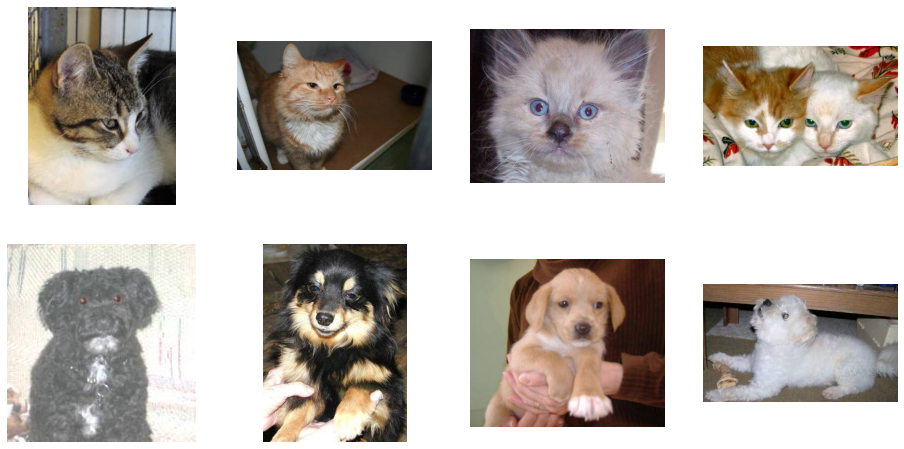

In [27]:
fig, axn = plt.subplots(num_classes, num_images, figsize=(num_images*4, num_classes*4))

for cls_name, row in zip(CLASS_NAMES, axn):
    idx = 0
    for ax in row:
        data_file = DATA_FILES[cls_name][subset][dir_idx + idx]
        img = mpimg.imread(data_file)
        ax.imshow(img)

        ax.grid(False)
        ax.set_axis_off()

        idx += 1


dir_idx += idx



In [28]:
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tfutils.visualize import plot_learning_curve
from sklearn import metrics as skmetrics

## Some Global Variables

In [39]:
TARGET_IMG_SHAPE = (150, 150)
NUM_CHANNELS = 3
INPUT_SHAPE = (*TARGET_IMG_SHAPE, NUM_CHANNELS)
N_CLASSES = 2 
BATCH_SIZE = 128
CLASSIFICATION_TYPE = 'binary'
RANDOM_STATE = 42
VALIDATION_SPLIT = 0.1

In [32]:
TFMODELS = {}
PREDICTIONS = {'train': {}, 'test': {}}

## Model 1: simple-cnn

In [34]:
model_name = 'simple-cnn'

In [35]:
model = tf.keras.models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "simple-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       1

### Preprocess the data


In [41]:
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=VALIDATION_SPLIT)
test_datagen = ImageDataGenerator(rescale=1/255.)

### Setup the directories

In [42]:
train_dir = DATA_DIR['train']
test_dir = DATA_DIR['test']

### Import Data From Directories

In [43]:
train_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                              subset='training', seed=RANDOM_STATE)
validation_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                                   subset='validation', seed=RANDOM_STATE)
test_gen = test_datagen.flow_from_directory(directory=test_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                            shuffle=False)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Fit the model

In [44]:
history = model.fit(train_gen, steps_per_epoch=len(train_gen), validation_data=validation_gen, validation_steps=len(validation_gen),
          epochs=15, batch_size=BATCH_SIZE)
TFMODELS[model_name] = model

Epoch 1/15
57/57 [==============================] - 22s 104ms/step - loss: 0.6946 - accuracy: 0.5050 - val_loss: 0.6844 - val_accuracy: 0.5150
Epoch 2/15
57/57 [==============================] - 6s 99ms/step - loss: 0.6696 - accuracy: 0.5939 - val_loss: 0.6756 - val_accuracy: 0.5600
Epoch 3/15
57/57 [==============================] - 6s 98ms/step - loss: 0.6368 - accuracy: 0.6428 - val_loss: 0.6383 - val_accuracy: 0.6300
Epoch 4/15
57/57 [==============================] - 6s 98ms/step - loss: 0.5955 - accuracy: 0.6889 - val_loss: 0.6194 - val_accuracy: 0.6400
Epoch 5/15
57/57 [==============================] - 6s 97ms/step - loss: 0.5722 - accuracy: 0.7033 - val_loss: 0.6379 - val_accuracy: 0.6200
Epoch 6/15
57/57 [==============================] - 6s 98ms/step - loss: 0.5442 - accuracy: 0.7289 - val_loss: 0.6309 - val_accuracy: 0.6150
Epoch 7/15
57/57 [==============================] - 6s 98ms/step - loss: 0.5326 - accuracy: 0.7311 - val_loss: 0.6217 - val_accuracy: 0.6650
Epoch 8/15


### Learning Curve

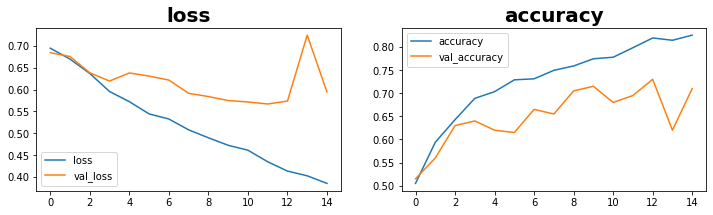

In [45]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [46]:
for subset in ['train', 'test']:
    PREDICTIONS[subset][model_name] = model.predict(test_gen)

## Model 2: simple-cnn-dropout

In [47]:
model_name = 'simple-cnn-dropout'

In [48]:
model = tf.keras.models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=INPUT_SHAPE),
    layers.Dropout(0.5),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Dropout(0.5),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "simple-cnn-dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 34, 128)

### Preprocess the data


In [49]:
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=VALIDATION_SPLIT)
test_datagen = ImageDataGenerator(rescale=1/255.)

### Setup the directories

In [50]:
train_dir = DATA_DIR['train']
test_dir = DATA_DIR['test']

### Import Data From Directories

In [51]:
train_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                              subset='training', seed=RANDOM_STATE)
validation_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                                   subset='validation', seed=RANDOM_STATE)
test_gen = test_datagen.flow_from_directory(directory=test_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                            shuffle=False)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Fit the model

In [52]:
history = model.fit(train_gen, steps_per_epoch=len(train_gen), validation_data=validation_gen, validation_steps=len(validation_gen),
          epochs=15, batch_size=BATCH_SIZE)
TFMODELS[model_name] = model

Epoch 1/15
57/57 [==============================] - 7s 105ms/step - loss: 0.6947 - accuracy: 0.5533 - val_loss: 0.6911 - val_accuracy: 0.5800
Epoch 2/15
57/57 [==============================] - 6s 99ms/step - loss: 0.6828 - accuracy: 0.5511 - val_loss: 0.6892 - val_accuracy: 0.5650
Epoch 3/15
57/57 [==============================] - 6s 100ms/step - loss: 0.6676 - accuracy: 0.5922 - val_loss: 0.6857 - val_accuracy: 0.5500
Epoch 4/15
57/57 [==============================] - 6s 99ms/step - loss: 0.6424 - accuracy: 0.6367 - val_loss: 0.6735 - val_accuracy: 0.5950
Epoch 5/15
57/57 [==============================] - 5s 93ms/step - loss: 0.6236 - accuracy: 0.6583 - val_loss: 0.6817 - val_accuracy: 0.5450
Epoch 6/15
57/57 [==============================] - 5s 93ms/step - loss: 0.6127 - accuracy: 0.6628 - val_loss: 0.6598 - val_accuracy: 0.6350
Epoch 7/15
57/57 [==============================] - 5s 93ms/step - loss: 0.5845 - accuracy: 0.6789 - val_loss: 0.6590 - val_accuracy: 0.6250
Epoch 8/15


### Learning Curve

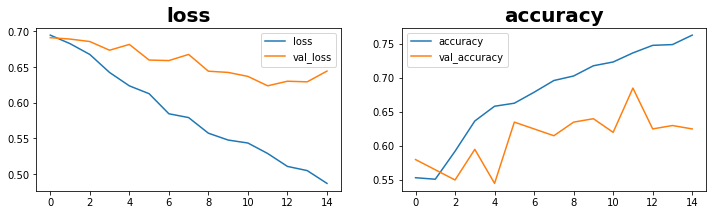

In [53]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [54]:
for subset in ['train', 'test']:
    PREDICTIONS[subset][model_name] = model.predict(test_gen)

### Comparing the two models

In [55]:
from tfutils.evaluate import ClassificationPerformanceComparer

preds = PREDICTIONS['test']
clf_comp = ClassificationPerformanceComparer.from_predictions(predictions=list(preds.values()), data=(None, test_gen.labels),
                                                              model_names=list(preds.keys()), class_names=CLASS_NAMES)
clf_comp.calculate_metric_comparison_df()

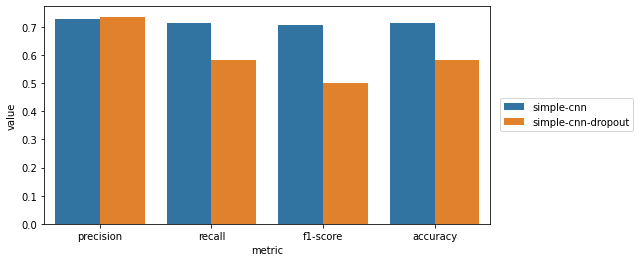

In [56]:
clf_comp.plot_metric_comparison_df()

Our Dropout model is possibly over-regularized and does not perform as good as the simple one. 

## Model 3: simple-cnn-data-aug

In [57]:
model_name = 'simple-cnn-data-aug'

In [58]:
model = tf.keras.models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "simple-cnn-data-aug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128

### Preprocess the data


In [59]:
train_datagen = ImageDataGenerator(rescale=1/255., 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=VALIDATION_SPLIT) 

validation_datagen = ImageDataGenerator(rescale=1/255., validation_split=VALIDATION_SPLIT)
test_datagen = ImageDataGenerator(rescale=1/255.)

### Setup the directories

In [60]:
train_dir = DATA_DIR['train']
test_dir = DATA_DIR['test']

### Import Data From Directories

In [61]:
train_gen = train_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                              subset='training', seed=RANDOM_STATE)
validation_gen = validation_datagen.flow_from_directory(directory=train_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                                   subset='validation', seed=RANDOM_STATE)
test_gen = test_datagen.flow_from_directory(directory=test_dir, target_size=TARGET_IMG_SHAPE, class_mode=CLASSIFICATION_TYPE,
                                            shuffle=False)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Fit the model

In [62]:
history = model.fit(train_gen, steps_per_epoch=len(train_gen), validation_data=validation_gen, validation_steps=len(validation_gen),
          epochs=15, batch_size=BATCH_SIZE)
TFMODELS[model_name] = model

Epoch 1/15
57/57 [==============================] - 14s 238ms/step - loss: 0.6948 - accuracy: 0.5211 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 2/15
57/57 [==============================] - 13s 232ms/step - loss: 0.6851 - accuracy: 0.5422 - val_loss: 0.6663 - val_accuracy: 0.6400
Epoch 3/15
57/57 [==============================] - 12s 219ms/step - loss: 0.6809 - accuracy: 0.5628 - val_loss: 0.6559 - val_accuracy: 0.6500
Epoch 4/15
57/57 [==============================] - 12s 219ms/step - loss: 0.6703 - accuracy: 0.5700 - val_loss: 0.6508 - val_accuracy: 0.6300
Epoch 5/15
57/57 [==============================] - 12s 217ms/step - loss: 0.6601 - accuracy: 0.6206 - val_loss: 0.6290 - val_accuracy: 0.6450
Epoch 6/15
57/57 [==============================] - 13s 233ms/step - loss: 0.6519 - accuracy: 0.6167 - val_loss: 0.6326 - val_accuracy: 0.6400
Epoch 7/15
57/57 [==============================] - 13s 234ms/step - loss: 0.6273 - accuracy: 0.6467 - val_loss: 0.6190 - val_accuracy: 0.6400

### Learning Curve

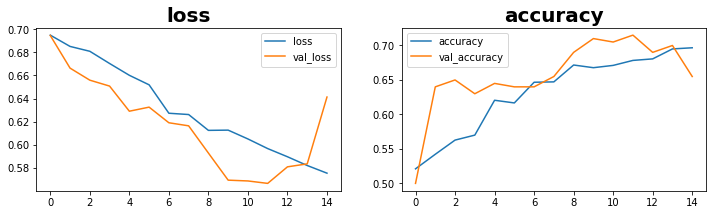

In [63]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [64]:
for subset in ['train', 'test']:
    PREDICTIONS[subset][model_name] = model.predict(test_gen)

## Performance Comparison

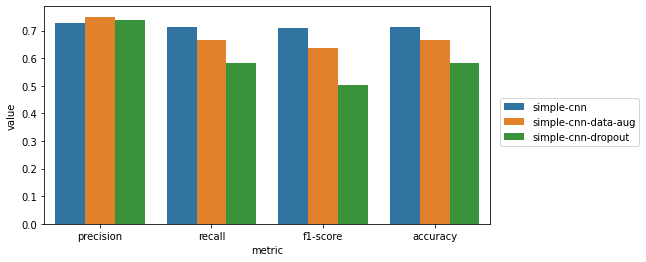

In [65]:
preds = PREDICTIONS['test']
clf_comp = ClassificationPerformanceComparer.from_predictions(predictions=list(preds.values()), data=(None, test_gen.labels),
                                                              model_names=list(preds.keys()), class_names=CLASS_NAMES)
clf_comp.calculate_metric_comparison_df()
clf_comp.plot_metric_comparison_df()

Wow! Data Augmentation hurt our results

## Model 4: Transfer Learning

In [77]:
model_name = 'inceptionv3-no-tune'

### Download Weights

In [66]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-07-23 11:15:37--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   115MB/s    in 0.7s    

2021-07-23 11:15:38 (115 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [79]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model = InceptionV3(include_top=False, weights=None)
pretrained_model.load_weights(weights_file)

### Freeze the model


In [80]:
for layer in pretrained_model.layers:
    layer.trainable = False


### Output Layer Shape


In [81]:
last_layer = pretrained_model.layers[-1]
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, None, None, 2048)


* The first `None` corresponds to number of data points
* The second and third `None` will be dependent on the dimension of the input image

In [90]:
inputs = layers.Input(shape=INPUT_SHAPE)
features = pretrained_model(inputs)
pooled = layers.GlobalAveragePooling2D()(features)
x = layers.Dense(512)(pooled)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name=model_name)
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(1e-4), 
              metrics=['accuracy'])

model.summary()

Model: "inceptionv3-no-tune"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 22,852,385
Trainable params: 1,049,601
Non-trainable params: 21,802,784
___________________________

In [93]:
history = model.fit(train_gen, steps_per_epoch=len(train_gen), validation_data=validation_gen,
                    validation_steps=len(validation_gen), epochs=15, batch_size=BATCH_SIZE)
TFMODELS[model_name] = model

Epoch 1/15
57/57 [==============================] - 19s 260ms/step - loss: 0.7040 - accuracy: 0.8250 - val_loss: 0.3700 - val_accuracy: 0.9100
Epoch 2/15
57/57 [==============================] - 13s 234ms/step - loss: 0.3606 - accuracy: 0.8850 - val_loss: 0.4485 - val_accuracy: 0.9150
Epoch 3/15
57/57 [==============================] - 13s 228ms/step - loss: 0.3432 - accuracy: 0.9083 - val_loss: 0.2270 - val_accuracy: 0.9500
Epoch 4/15
57/57 [==============================] - 13s 226ms/step - loss: 0.3440 - accuracy: 0.8989 - val_loss: 0.1296 - val_accuracy: 0.9550
Epoch 5/15
57/57 [==============================] - 13s 232ms/step - loss: 0.3558 - accuracy: 0.8989 - val_loss: 0.2950 - val_accuracy: 0.9500
Epoch 6/15
57/57 [==============================] - 14s 242ms/step - loss: 0.2867 - accuracy: 0.9144 - val_loss: 0.1514 - val_accuracy: 0.9450
Epoch 7/15
57/57 [==============================] - 13s 234ms/step - loss: 0.3183 - accuracy: 0.9117 - val_loss: 0.1195 - val_accuracy: 0.9500

### Learning Curve

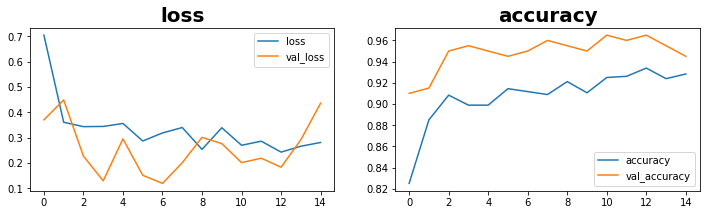

In [95]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [96]:
for subset in ['train', 'test']:
    PREDICTIONS[subset][model_name] = model.predict(test_gen)

## Performance Comparison

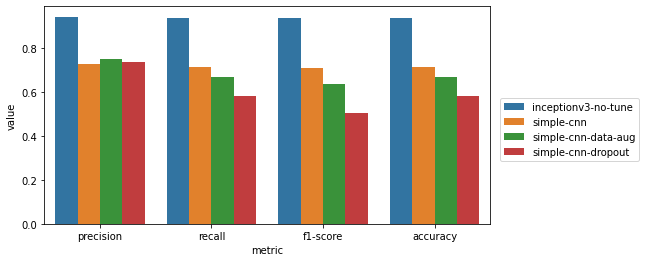

In [97]:
preds = PREDICTIONS['test']
clf_comp = ClassificationPerformanceComparer.from_predictions(predictions=list(preds.values()), data=(None, test_gen.labels),
                                                              model_names=list(preds.keys()), class_names=CLASS_NAMES)
clf_comp.calculate_metric_comparison_df()
clf_comp.plot_metric_comparison_df()

Transfer learning rocks! 

In [111]:
from tfutils.image import visualize_convolutions

In [112]:
def load_img(fpath):
    img = tf.keras.preprocessing.image.load_img(fpath, target_size=TARGET_IMG_SHAPE)
    img = tf.keras.preprocessing.image.img_to_array(img)

    return img


def preprocess_img(img):
    return np.expand_dims(img, axis=0)/255.

In [114]:
import random

fpath = random.choice(DATA_FILES['cats']['train'])
img = load_img(fpath)
img_prep = preprocess_img(img)

/content/drive/MyDrive/projects/tfutils/tfutils/image/visualize_conv.py:28: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


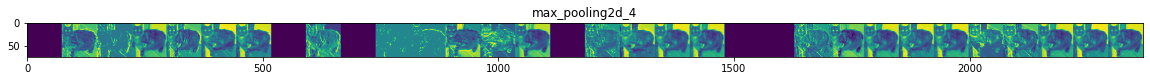

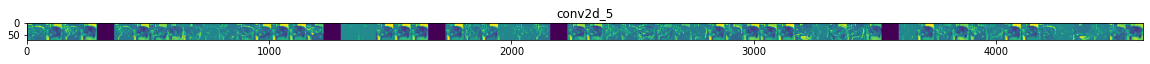

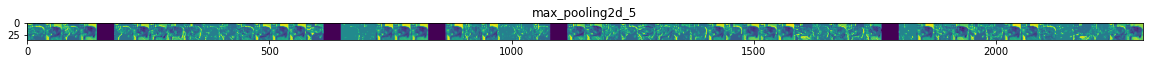

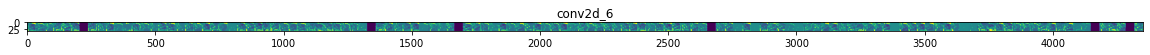

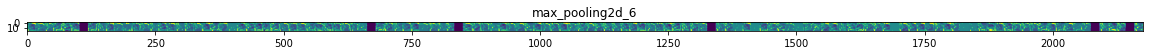

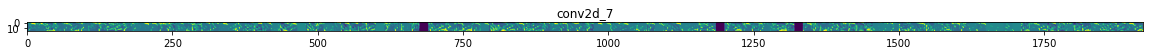

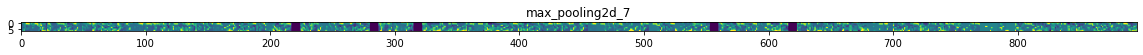

In [115]:
visualize_convolutions(TFMODELS['simple-cnn'], img_prep)